In [1]:
import pandas as pd
import yaml
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
rushes = pd.read_csv('zip_data.csv', index_col=0)
rushes['play_end_ydline'] = (rushes['yardline_100'] - rushes['yards_gained'])

C:\Users\Sharedw\AppData\Local\Temp\ipykernel_8552\2929713968.py:1: DtypeWarning: Columns (54,187,188,219,220,221,223,225,227,234,235,236,237,238,239,254,255,256,261,263,264,284,285,371,373,374,375,377,379,380,381) have mixed types. Specify dtype option on import or set low_memory=False.
  rushes = pd.read_csv('zip_data.csv', index_col=0)


In [3]:

def create_model(df, x_cols, y_col):
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBClassifier( eval_metric='mlogloss')
    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:')
    display(cm)
    return model


def create_reg_model(df, x_cols, y_col):
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    residuals = y_test - y_pred

    return model


In [5]:
game_context_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    #"yards_gained",
    "posteam_score",
    #"total_away_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    #"wind",
    #"temp",
    'spread_line',
    'total_line'
]

team_rb_cols = [
    "ppr_roll_RB_0",
    "ppr_roll_RB_1",
    "ppr_roll_RB_2",
    "rush_roll_RB_0",
    "rush_roll_RB_1",
    "rush_roll_RB_2",
    "carries_roll_RB_1",
    "carries_roll_RB_2",
    "carries_roll_RB_0",
]
rusher_stats = ['ppr_roll','rush_roll']

full = ['desc','yards_gained','yards_quantile', 'play_end_ydline'] + game_context_cols + team_rb_cols + rusher_stats 

In [6]:
rush_yards_cols = (game_context_cols + rusher_stats)
rush_quantile_model = create_model(rushes, x_cols=rush_yards_cols, y_col='yards_quantile')

Accuracy: 0.30
Confusion Matrix:


array([[1179,   66,  354,  185,  110],
       [ 465,   39,  168,   78,   43],
       [ 743,   39,  333,  134,   99],
       [ 525,   27,  236,  129,   74],
       [ 544,   23,  214,  116,  112]], dtype=int64)

In [7]:
new = rushes.loc[~rushes.down.isna()][full].copy(deep=True)

In [8]:
new['pred_quantile'] = rush_quantile_model.predict(new[rush_yards_cols]).round()

In [12]:
X = torch.Tensor(new[rush_yards_cols].values)
Y = torch.Tensor(new['play_end_ydline'].values)

In [16]:
new['yards_shifted'] = (new['yards_gained'] + 20)

In [17]:
new['yards_shifted'].min()

7.0

In [54]:
rush_yards_cols = ['yardline_100','down','ppr_roll']
new[rush_yards_cols]

,yardline_100,down,ppr_roll
0,43.0,2.0,7.750000
1,36.0,3.0,7.750000
2,39.0,2.0,7.750000
3,93.0,2.0,7.750000
5,73.0,2.0,5.300000
...,...,...,...
30167,85.0,1.0,5.433333
30168,75.0,1.0,5.433333
30169,73.0,2.0,5.433333
30170,59.0,1.0,5.433333


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

X = torch.Tensor(new[rush_yards_cols].values)
y = torch.tensor(new['yards_shifted'].astype(int).values, dtype=torch.long)

# Update the model to match the input and output sizes
class ThreeLayerClassifier(nn.Module):
    def __init__(self, input_size=3, hidden_size=50, output_size=110):
        super(ThreeLayerClassifier, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size + 1, output_size)  # +1 for the additional feature
    def forward(self, x):
        # Extract the feature to pass to the final layer (e.g., the first feature)
        feature_to_pass = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]
        
        # Pass through the first two layers
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        
        # Concatenate the extracted feature with the output of the hidden layers
        x = torch.cat((x, feature_to_pass), dim=1)  # Concatenate along the feature axis (dim=1)
        
        # Pass through the final layer
        x = self.output_layer(x)
        return x


# Define the model, loss function, and optimizer
model = ThreeLayerClassifier()
criterion = nn.CrossEntropyLoss()  # Suitable for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Split data into training and testing sets
train_X, test_X = X[:24000], X[24000:]
train_y, test_y = y[:24000], y[24000:]

# Training loop
epochs = 10
batch_size = 256

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(train_X.size(0))
    epoch_loss = 0

    for i in range(0, train_X.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_X, batch_y = train_X[indices], train_y[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)  # Shape: [batch_size, 100]
        loss = criterion(outputs, batch_y)  # batch_y must be [batch_size] with class indices
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_X):.4f}")

# Evaluation on the test set
model.eval()
with torch.no_grad():
    test_preds = model(test_X)  # Shape: [num_samples, 100]
    test_loss = criterion(test_preds, test_y).item()
    accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")


Epoch 1/10, Loss: 0.0176
Epoch 2/10, Loss: 0.0113
Epoch 3/10, Loss: 0.0113
Epoch 4/10, Loss: 0.0112
Epoch 5/10, Loss: 0.0112
Epoch 6/10, Loss: 0.0111
Epoch 7/10, Loss: 0.0111
Epoch 8/10, Loss: 0.0111
Epoch 9/10, Loss: 0.0111
Epoch 10/10, Loss: 0.0111
Test Loss: 2.8331, Test Accuracy: 0.1283


In [67]:
model_path = "models/run_yards_gained.pt"
torch.save(model.state_dict(), model_path)

torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])


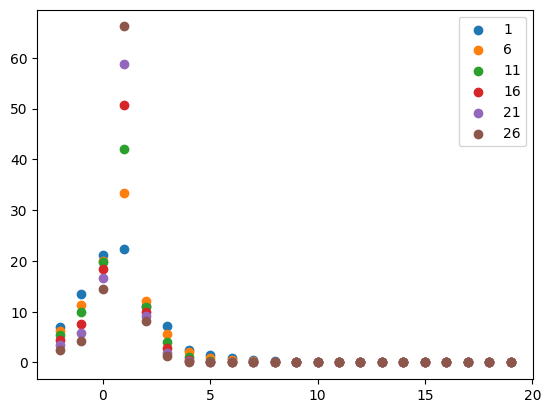

In [64]:
for ppr in range(1,30,5):
    yardline=1
    xx = torch.tensor([[yardline,1. ,ppr]])
    print(xx.shape)
    with torch.no_grad():
        xy = model(xx)
        xy = 100 * F.softmax(xy,dim=1)
        x_range = range(-2,20)
    plt.scatter(x_range, xy[:,18:40], label=ppr)

plt.legend()

In [71]:
import torch.nn.functional as F

def test_yardline(data, yards, model):
    df = data.loc[data.yardline_100 == yards].copy(deep=True)
    X = torch.tensor(df[rush_yards_cols].values, dtype=torch.float32)
    print(X.shape)
    with torch.no_grad():
        logits = model(X)
        log_probs = F.log_softmax(logits, dim=1)
    real = df['yards_gained'].values
    return real, log_probs

real, preds = test_yardline(new, 5, ThreeLayerClassifier())
preds

torch.Size([254, 3])


tensor([[-4.9983, -4.7414, -5.2373,  ..., -5.6698, -5.3637, -5.5804],
        [-5.0142, -4.7916, -5.0606,  ..., -5.5810, -5.3017, -5.5484],
        [-4.5986, -4.9628, -5.9550,  ..., -5.7484, -5.1854, -6.3954],
        ...,
        [-4.5542, -4.9491, -6.1617,  ..., -5.8390, -5.1745, -6.6061],
        [-4.5258, -5.0202, -6.1449,  ..., -5.7696, -5.1890, -6.6136],
        [-5.0164, -4.7791, -5.1175,  ..., -5.6100, -5.3129, -5.5597]])

In [73]:
model(X[0].reshape(1,-1))

tensor([[ -7.4983, -15.6217, -15.2593,  -7.4945,  -5.7590, -16.8270, -12.2715,
          -5.0731, -16.4356, -16.7469,  -6.2904, -12.7241,  -1.8738,  -0.8459,
          -0.6888,  -0.3017,   1.2072,   1.0621,   1.6711,   2.0845,   3.0938,
           3.0846,   3.3138,   3.2260,   3.0214,   2.8779,   2.4972,   2.1185,
           1.8356,   1.9796,   1.2601,   0.9370,   0.6646,   1.0711,   0.7168,
           0.3206,   0.1598,   0.1108,  -0.5120,  -0.2080,  -0.5567,  -0.3647,
          -0.2570,  -0.9358,  -1.0829,  -0.9672,  -1.2587,  -1.4058,  -1.2585,
          -1.7257,  -1.5233,  -1.2907,  -1.6518,  -3.0474,  -2.6075,  -1.1923,
          -1.4342,  -2.0244,  -2.1151,  -1.9167,  -1.2660,  -2.0637,  -1.8047,
          -2.4966,  -2.2961,  -3.2006,  -4.1376, -13.7330,  -3.3040,  -1.7957,
          -3.1017,  -3.9171,  -3.3366,  -2.9711,  -3.7340,  -2.8022,  -3.0358,
          -3.9967,  -3.9547, -12.3658,  -2.8627,  -3.4474,  -2.7497,  -2.4836,
          -3.6825,  -4.1223,  -3.5704,  -3.2876,  -3

<Axes: >

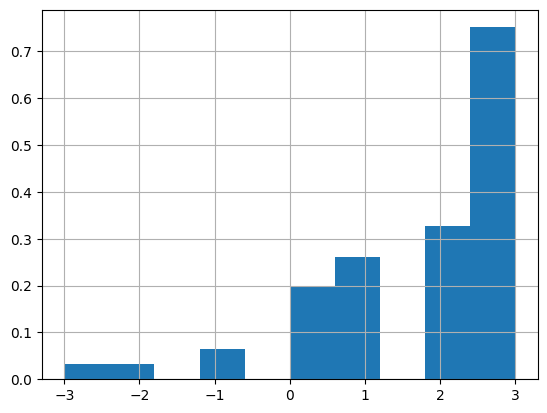

In [84]:
new.loc[(new.yardline_100 == 3) & (new.ppr_roll > 17)]['yards_gained'].hist(density=True)

In [82]:
new.loc[(new.yardline_100 == 3) & (new.ppr_roll > 20)]['yards_gained'].values

array([ 3.,  2.,  3.,  3., -2.,  1.,  1.,  3.,  2.,  2.,  1.,  3.,  3.,
        3.,  3.,  3.,  3.])

In [98]:
rushes.loc[(rushes.yardline_100 == 3)]['yards_gained'].value_counts()

yards_gained
 3.0    87
 2.0    49
 0.0    37
 1.0    30
-1.0    21
-2.0    17
-4.0     3
-3.0     1
-7.0     1
Name: count, dtype: int64

In [92]:
rushes.loc[rushes.rusher == 'S.Barkley']

,player_id,ppr_roll,rush_roll,week,season,play_id,game_id,old_game_id,home_team,away_team,...,carries_roll_RB_1,carries_roll_RB_2,carries_roll_RB_0,rusher_depth_num,yards_quantile,pred_quantile,pred_yards,residuals,calc_end,play_end_ydline
5125,00-0034844,13.866667,73.666667,1,2022,62.0,2022_01_NYG_TEN,NaN,TEN,NYG,...,0.666667,0.000000,16.000000,0.0,0,0,0.414951,-0.585049,77.0,77.0
5126,00-0034844,13.866667,73.666667,1,2022,947.0,2022_01_NYG_TEN,NaN,TEN,NYG,...,0.666667,0.000000,16.000000,0.0,2,0,3.700843,-0.299157,71.0,71.0
5127,00-0034844,13.866667,73.666667,1,2022,968.0,2022_01_NYG_TEN,NaN,TEN,NYG,...,0.666667,0.000000,16.000000,0.0,4,0,19.014664,4.014664,56.0,56.0
5128,00-0034844,13.866667,73.666667,1,2022,1039.0,2022_01_NYG_TEN,NaN,TEN,NYG,...,0.666667,0.000000,16.000000,0.0,1,0,1.981137,-0.018863,42.0,42.0
5129,00-0034844,13.866667,73.666667,1,2022,1333.0,2022_01_NYG_TEN,NaN,TEN,NYG,...,0.666667,0.000000,16.000000,0.0,3,2,6.303679,-0.696321,69.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25138,00-0034844,20.283334,117.000000,11,2024,3511.0,2024_11_WAS_PHI,2.024111e+09,PHI,WAS,...,6.166667,6.333333,20.666667,0.0,2,2,3.650193,0.650193,71.0,71.0
25139,00-0034844,20.283334,117.000000,11,2024,3586.0,2024_11_WAS_PHI,2.024111e+09,PHI,WAS,...,6.166667,6.333333,20.666667,0.0,0,0,0.022016,-0.977984,29.0,29.0
25140,00-0034844,20.283334,117.000000,11,2024,3633.0,2024_11_WAS_PHI,2.024111e+09,PHI,WAS,...,6.166667,6.333333,20.666667,0.0,4,0,20.225922,-2.774078,0.0,0.0
25141,00-0034844,20.283334,117.000000,11,2024,3722.0,2024_11_WAS_PHI,2.024111e+09,PHI,WAS,...,6.166667,6.333333,20.666667,0.0,3,0,6.270894,-0.729106,39.0,39.0


In [91]:
rushes.rusher

0        M.Ingram
1        M.Ingram
2        M.Ingram
3        M.Ingram
4        M.Ingram
           ...   
30167    T.Benson
30168    T.Benson
30169    T.Benson
30170    T.Benson
30171    T.Benson
Name: rusher, Length: 30172, dtype: object